In [495]:
import matplotlib.pyplot as plt
import torch
import torchvision

tensor([[-0.1162],
        [ 0.0307],
        [ 0.0243],
        [-0.0304]])

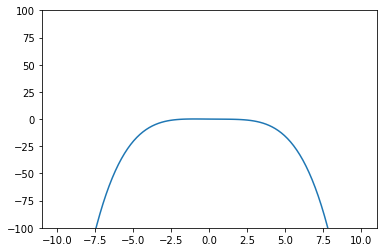

In [491]:
parameter_scale = 0.01

x = torch.linspace(-10, 10, 100)

poly_order = 4
powers = torch.tensor([p + 1 for p in range(poly_order)])
x_poly = x.unsqueeze(-1).pow(powers)

coefficients = torch.randn(poly_order, 1) * parameter_scale

y = x_poly @ coefficients

plt.plot(x, y);
plt.ylim([-100, 100])

coefficients

In [525]:
num_epochs = 4
learning_rate = 0.1
batch_size = 128
weight_decay = 0.001
dropout_rate = 0.2

In [498]:
data_directory_path = '../data/'

mnist_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

# Training data loader
train_dataset = torchvision.datasets.MNIST(
    root=data_directory_path, train=True, download=True, transform=mnist_transforms
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

# Validation data loader
valid_dataset = torchvision.datasets.MNIST(
    root=data_directory_path, train=False, download=True, transform=mnist_transforms
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=len(valid_dataset), shuffle=True
)

In [513]:
nx = 28 * 28
ny = 10
shapes = (nx, 20, 20, 20, ny)

layers = [
    torch.nn.Sequential(torch.nn.Linear(n_in, n_out), torch.nn.ReLU())
    for n_in, n_out in zip(shapes, shapes[1:-1])
]

layers.append(torch.nn.Linear(shapes[-2], shapes[-1]))

model = torch.nn.Sequential(*layers)

loss = torch.nn.CrossEntropyLoss()

valid_costs = []
train_costs = []
accuracies = []

for epoch in range(num_epochs):

    # Set model to training mode
    model.train()

    # Update the model for each batch
    train_count = 0
    train_cost = 0
    for X, y in train_loader:

        # Compute model cost
        yhat = model(X.view(-1, nx))
        cost = loss(yhat, y)

        # Compute gradients
        model.zero_grad()
        cost.backward()

        # Update parameters
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad

        train_count += X.shape[0]
        train_cost += cost.item()

    # Set model to evaluation mode
    model.eval()

    # Test model on validation data
    valid_count = 0
    valid_cost = 0
    valid_correct = 0
    with torch.no_grad():
        for X, y in valid_loader:

            # Compute model cost
            yhat = model(X.view(-1, nx))
            cost = loss(yhat, y)

            # Convert model output into discrete predictions
            predictions = yhat.argmax(dim=1, keepdim=True)

            # Compute number correct
            correct = predictions.eq(y.view_as(predictions)).double().sum().item()

            valid_count += X.shape[0]
            valid_cost += cost.item()
            valid_correct += correct

    train_cost /= train_count
    valid_cost /= valid_count
    valid_accuracy = valid_correct / valid_count

    ep_str = f"{epoch+1:>2}/{num_epochs}"
    tc_str = f"{train_cost:.2e}"
    vc_str = f"{valid_cost:.2e}"
    va_str = f"{valid_accuracy*100:.2f}"
    print(f"{ep_str}: TC={tc_str}, VC={vc_str}, Accuracy={va_str}%")

    train_costs.append(train_cost)
    valid_costs.append(valid_cost)
    accuracies.append(valid_accuracy)
    
    with torch.no_grad():
        for layer in model.parameters():
            print(layer.data.abs().mean())

print("Done.")

 1/4: TC=4.92e-03, VC=2.89e-05, Accuracy=91.32%
tensor(0.0265)
tensor(0.0217)
tensor(0.1646)
tensor(0.0934)
tensor(0.1607)
tensor(0.1482)
tensor(0.2001)
tensor(0.1507)
 2/4: TC=1.89e-03, VC=2.50e-05, Accuracy=92.31%
tensor(0.0300)
tensor(0.0226)
tensor(0.1772)
tensor(0.0927)
tensor(0.1718)
tensor(0.1490)
tensor(0.2163)
tensor(0.1591)
 3/4: TC=1.46e-03, VC=1.65e-05, Accuracy=94.80%
tensor(0.0325)
tensor(0.0239)
tensor(0.1854)
tensor(0.0920)
tensor(0.1774)
tensor(0.1485)
tensor(0.2253)
tensor(0.1673)
 4/4: TC=1.26e-03, VC=2.11e-05, Accuracy=93.48%
tensor(0.0345)
tensor(0.0244)
tensor(0.1923)
tensor(0.0911)
tensor(0.1810)
tensor(0.1475)
tensor(0.2315)
tensor(0.1737)
Done.


In [522]:
nx = 28 * 28
ny = 10
shapes = (nx, 20, 20, 20, ny)

layers = [
    torch.nn.Sequential(torch.nn.Linear(n_in, n_out), torch.nn.ReLU())
    for n_in, n_out in zip(shapes, shapes[1:-1])
]

layers.append(torch.nn.Linear(shapes[-2], shapes[-1]))

model = torch.nn.Sequential(*layers)

loss = torch.nn.CrossEntropyLoss()

valid_costs = []
train_costs = []
accuracies = []

for epoch in range(num_epochs):

    # Set model to training mode
    model.train()

    # Update the model for each batch
    train_count = 0
    train_cost = 0
    for X, y in train_loader:

        # Compute model cost
        yhat = model(X.view(-1, nx))
        cost = loss(yhat, y)

        # Compute gradients
        model.zero_grad()
        cost.backward()

        # Update parameters
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad + weight_decay * param

        train_count += X.shape[0]
        train_cost += cost.item()

    # Set model to evaluation mode
    model.eval()

    # Test model on validation data
    valid_count = 0
    valid_cost = 0
    valid_correct = 0
    with torch.no_grad():
        for X, y in valid_loader:

            # Compute model cost
            yhat = model(X.view(-1, nx))
            cost = loss(yhat, y)

            # Convert model output into discrete predictions
            predictions = yhat.argmax(dim=1, keepdim=True)

            # Compute number correct
            correct = predictions.eq(y.view_as(predictions)).double().sum().item()

            valid_count += X.shape[0]
            valid_cost += cost.item()
            valid_correct += correct

    train_cost /= train_count
    valid_cost /= valid_count
    valid_accuracy = valid_correct / valid_count

    ep_str = f"{epoch+1:>2}/{num_epochs}"
    tc_str = f"{train_cost:.2e}"
    vc_str = f"{valid_cost:.2e}"
    va_str = f"{valid_accuracy*100:.2f}"
    print(f"{ep_str}: TC={tc_str}, VC={vc_str}, Accuracy={va_str}%")

    train_costs.append(train_cost)
    valid_costs.append(valid_cost)
    accuracies.append(valid_accuracy)
    
    with torch.no_grad():
        for layer in model.parameters():
            print(layer.data.abs().mean())

print("Done.")

 1/4: TC=5.13e-03, VC=3.11e-05, Accuracy=90.02%
tensor(0.0204)
tensor(0.0198)
tensor(0.1275)
tensor(0.0599)
tensor(0.1261)
tensor(0.0834)
tensor(0.1781)
tensor(0.0818)
 2/4: TC=2.15e-03, VC=2.27e-05, Accuracy=93.42%
tensor(0.0195)
tensor(0.0156)
tensor(0.1235)
tensor(0.0428)
tensor(0.1184)
tensor(0.0513)
tensor(0.1768)
tensor(0.0576)
 3/4: TC=1.83e-03, VC=2.05e-05, Accuracy=93.82%
tensor(0.0189)
tensor(0.0131)
tensor(0.1220)
tensor(0.0331)
tensor(0.1140)
tensor(0.0324)
tensor(0.1752)
tensor(0.0385)
 4/4: TC=1.71e-03, VC=2.02e-05, Accuracy=94.27%
tensor(0.0187)
tensor(0.0114)
tensor(0.1221)
tensor(0.0274)
tensor(0.1113)
tensor(0.0247)
tensor(0.1741)
tensor(0.0280)
Done.


In [532]:
num_epochs = 20
batch_size = 1024
weight_decay = 0.001
dropout_rate = 0.2

nx = 28 * 28
ny = 10
shapes = (nx, 20, 20, 20, ny)


def create_layer(n_in, n_out):
    return torch.nn.Sequential(
        torch.nn.Linear(n_in, n_out),
        torch.nn.BatchNorm1d(n_out),
        torch.nn.Dropout(dropout_rate),
        torch.nn.ReLU(),
    )


layers = [create_layer(n_in, n_out) for n_in, n_out in zip(shapes, shapes[1:-1])]
layers.append(torch.nn.Linear(shapes[-2], shapes[-1]))

model = torch.nn.Sequential(*layers)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay)

valid_costs = []
train_costs = []
accuracies = []

for epoch in range(num_epochs):

    # Set model to training mode
    model.train()

    # Update the model for each batch
    train_count = 0
    train_cost = 0
    for X, y in train_loader:

        # Compute model cost
        yhat = model(X.view(-1, nx))
        cost = loss(yhat, y)

        # Compute gradients
        optimizer.zero_grad()
        cost.backward()

        # Update parameters
        optimizer.step()

        train_count += X.shape[0]
        train_cost += cost.item()

    # Set model to evaluation mode
    model.eval()

    # Test model on validation data
    valid_count = 0
    valid_cost = 0
    valid_correct = 0
    with torch.no_grad():
        for X, y in valid_loader:

            # Compute model cost
            yhat = model(X.view(-1, nx))
            cost = loss(yhat, y)

            # Convert model output into discrete predictions
            predictions = yhat.argmax(dim=1, keepdim=True)

            # Compute number correct
            correct = predictions.eq(y.view_as(predictions)).double().sum().item()

            valid_count += X.shape[0]
            valid_cost += cost.item()
            valid_correct += correct

    train_cost /= train_count
    valid_cost /= valid_count
    valid_accuracy = valid_correct / valid_count

    ep_str = f"{epoch+1:>2}/{num_epochs}"
    tc_str = f"{train_cost:.2e}"
    vc_str = f"{valid_cost:.2e}"
    va_str = f"{valid_accuracy*100:.2f}"
    print(f"{ep_str}: TC={tc_str}, VC={vc_str}, Accuracy={va_str}%")

    train_costs.append(train_cost)
    valid_costs.append(valid_cost)
    accuracies.append(valid_accuracy)

print("Done.")

 1/20: TC=8.65e-03, VC=3.54e-05, Accuracy=91.42%
 2/20: TC=4.84e-03, VC=2.68e-05, Accuracy=92.79%
 3/20: TC=4.24e-03, VC=2.37e-05, Accuracy=93.45%
 4/20: TC=3.94e-03, VC=2.25e-05, Accuracy=93.68%
 5/20: TC=3.76e-03, VC=2.11e-05, Accuracy=94.22%
 6/20: TC=3.62e-03, VC=2.00e-05, Accuracy=94.54%
 7/20: TC=3.50e-03, VC=1.99e-05, Accuracy=94.41%
 8/20: TC=3.45e-03, VC=1.97e-05, Accuracy=94.42%
 9/20: TC=3.35e-03, VC=1.92e-05, Accuracy=94.69%
10/20: TC=3.37e-03, VC=1.92e-05, Accuracy=94.61%
11/20: TC=3.29e-03, VC=1.86e-05, Accuracy=94.63%
12/20: TC=3.24e-03, VC=1.90e-05, Accuracy=94.77%
13/20: TC=3.22e-03, VC=1.92e-05, Accuracy=94.57%
14/20: TC=3.25e-03, VC=1.84e-05, Accuracy=94.81%
15/20: TC=3.18e-03, VC=1.79e-05, Accuracy=94.97%
16/20: TC=3.21e-03, VC=1.82e-05, Accuracy=94.82%
17/20: TC=3.17e-03, VC=1.90e-05, Accuracy=94.65%
18/20: TC=3.14e-03, VC=1.82e-05, Accuracy=94.74%
19/20: TC=3.14e-03, VC=1.81e-05, Accuracy=95.04%
20/20: TC=3.14e-03, VC=1.87e-05, Accuracy=94.69%
Done.


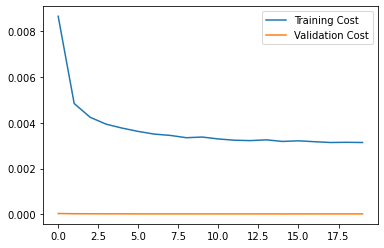

In [533]:
plt.plot(train_costs, label='Training Cost')
plt.plot(valid_costs, label='Validation Cost')
plt.legend();